#### Notebook to split AMP-PD whole-blood expression by cohort
probably also want to go head and split by visit as well

In [1]:
!date

Wed Apr 28 17:21:49 UTC 2021


#### do imports and set notebooks variables

In [2]:
import pandas as pd
import numpy as np
import concurrent.futures
import random
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from umap import UMAP
import ppscore as pps
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
# variables
cohort = 'amppd'
quant_type = 'genes'

# directories
wrk_dir = f'/home/jupyter/{cohort}'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'

# input files
quants_local_file = f'{expr_dir}/matrix.{quant_type}.tsv'
gencode_pkl = f'{expr_dir}/gencode.v29.primary_assembly.annotation.pkl'
covariates_file = f'{info_dir}/{cohort}_rna_sample_info.csv'
outlier_samples_file = f'{info_dir}/outliers.txt'

# output files
all_expr_file = f'{expr_dir}/{cohort}.{quant_type}.hdf5'
umap_covs_file = f'{info_dir}/{cohort}_rna.umap.covs.csv'
norm_file = f'{expr_dir}/{cohort}.{quant_type}.norm.genes.hd5f'
adj_expr_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.hdf5'
tnsrqtl_pheno_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.bed'
feature_ids_exclude_var_file = f'{expr_dir}/{cohort}.{quant_type}.variance.features.exclude.txt'

# gene file of genes to exclude from variance detection
# using Human Protein Atlas 'elevated' gene set for blood
tissue_genes_file = f'{expr_dir}/blood.elevated.features_targets.csv'

# constants
max_missing_rate = 0.25
min_ppscore = 0.05
min_pearson = 0.22

other_id_columns = ['idpart', 'participant_id', 'wgsid']

### notebook functions

#### functions for detection rates calculations and plotting

In [4]:
def calculate_detection_rates(this_df, quant_type, round_percision=1, 
                              min_expr_value=None):
    if min_expr_value is None:
        min_expr_value = expr_df.round(round_percision).min().min()

    print(f'minimun {quant_type} value is {min_expr_value}')

    detected_df = this_df.mask(this_df.round(round_percision) <= min_expr_value, 0)

    # calculate the missing counts from the detected df mask
    trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
    sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

    print(f'{len(trait_missing_rates)} features with mean missing \
rate = {trait_missing_rates.mean()}')
    print(f'{len(sample_missing_rates)} samples with mean missing \
rate = {sample_missing_rates.mean()}')
    return trait_missing_rates, sample_missing_rates

def plot_missing_rates(feature_rates, sample_rates):
    sns.set()
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    sns.distplot(feature_rates.values)
    plt.title('Features missingness rates')
    plt.subplot(2, 2, 2)
    sns.distplot(sample_rates.values)
    plt.title('Samples missingness rates')
    plt.show()
    
def bad_callrate_features(features_missing_rates, max_missing_rate):
    bad_call_rates = features_missing_rates[features_missing_rates > max_missing_rate]
    print(f'features with bad call rates shape {bad_call_rates.shape}, \
fraction of features with bad rates {bad_call_rates.shape[0]/expr_df.shape[1]}')
    return bad_call_rates

def subset_well_detected_features(this_df, bad_call_rates):
    detected_traits = list(set(this_df.columns)-set(bad_call_rates.index))
    this_wd_df = this_df[detected_traits]
    print(f'shape of well detected quants {this_wd_df.shape}')
    return this_wd_df

#### function to generate and visualize known and unknow covariates using UMAP and PPScore

In [5]:
# function for plotting umap of traits with covar high lights
def plot_umap_clusters(umap_df, hue_cov=None, style_cov=None, size_cov=None):
    # umap_plot_file = f'{WRKDIR}/{COHORTBUILD}.umap.residuals.umap.plot.png'
    sns.set()
    plt.figure(figsize=(12,12))
    sns_plot = sns.scatterplot(x='x_umap',y='y_umap', \
                               hue=hue_cov, style=style_cov, size=size_cov, \
                               data=umap_df)
    plt.xlabel('x-umap')
    plt.ylabel('y-umap')
    #plt.legend(loc='lower right', prop={'size': 6})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 10})
    # plt.savefig(umap_plot_file,format='png',dpi=600,bbox_inches='tight')
    plt.show()

# small function to generate umap from pandas dataframe, for all features (columns) \
# and return back as dataframe with source index intact
def generate_umap_covs_df(this_df, other_covs_df=None, 
                             rnd_digits=3, merge_input=False):
    #run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results,columns=['x_umap','y_umap'], \
                                       index=this_df.index).round(rnd_digits)
    if merge_input:
        umap_df = umap_df.merge(this_df,left_index=True,right_index=True)
    if other_covs_df is not None:
        umap_df = umap_df.merge(other_covs_df, how='left', 
                                left_index=True, right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df 

# function to iterate over target features and use PPScore to find covarites of interest
def pps_predict_targets(this_df, target_list):
    covs_to_check = []
#     covs_list = ['x_umap', 'y_umap']
    for this_cov in target_list:
        print(this_cov)
        predictors_df = pps.predictors(this_df, this_cov)
        # drop anything that has ppscore of zero
        predictors_df = predictors_df.loc[predictors_df['ppscore'] > min_ppscore]
        display(predictors_df)
        covs_to_check.extend(list(predictors_df['x'].values))

    print(f'found {len(covs_to_check)} covariates that may preditct target covariates')    
    return covs_to_check

# plot ppscore matrix 
def plot_ppscore_matrix(this_df, covs_to_check, cov_targets):
    matrix_df = pps.matrix(this_df[(set(covs_to_check) | set(cov_targets))])
    matrix_df = matrix_df.loc[matrix_df['ppscore'] > min_ppscore]
    print(matrix_df.shape)

    matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
    plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    print(plot_matrix_df.shape)
    # display(plot_matrix_df)

    plt.figure(figsize=(plot_matrix_df.shape[0],plot_matrix_df.shape[1])) 
    sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap='Blues', linewidths=0.05, 
                annot=True, annot_kws={'fontsize':12})
    plt.title('PPScore heatmap')
    plt.show()
    
# plot heatmap of Pearson correlation matrix for PPScore covariates
def plot_correlation_heatmap(this_df, covs_list : list=None):
    sns.set()
    cor = this_df.corr(method='pearson')
    cor.dropna(how='all', inplace=True)
    modified_title = ''
    if covs_list is not None:
        
        limited_cor = cor[covs_list]
        cor = limited_cor.loc[(limited_cor['x_umap'].abs() > min_pearson) | 
                              (limited_cor['y_umap'].abs() > min_pearson)]
        modified_title = 'limited'
    print(cor.shape)
    fig_width = cor.shape[1] if cor.shape[1] > 6 else 6
    fig_height = cor.shape[0] if cor.shape[1] > 6 else 6
    plt.figure(figsize=(fig_width, fig_height))        
    sns.heatmap(cor[(cor > min_pearson) | (cor < -min_pearson)], annot=True, 
                annot_kws={"fontsize":10}, linewidths=0.05, cmap='Blues')    
    plt.title(f'Pearson heatmap of PPScore covariates {modified_title}')
    plt.show()

# function to one-hot encode the categorical covariates and merge with continuous ones    
def dummy_covs_as_needed(this_df):
    temp_df = this_df.copy()
    cats_df = temp_df.select_dtypes(include=['object'])
    print(f'categoricals shape {cats_df.shape}')
    dums_df = pd.get_dummies(cats_df)
    print(f'one-hot encoded categoricals shape {dums_df.shape}')

    temp_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
    print(f'new covs df shape {temp_df.shape}')
    return temp_df    

#### visualization functions

In [6]:
# small function to plot before and after of transform based on named feature,
# or if a feature isn't specified then one pull at random
def plot_trnsfrm_effect_example(before_df, after_df, feature_id=None,
                                bf_label='quantile transformed', 
                                af_label='quantile transformed and covariate adjusted'):
    # if no feature ID provided get randome one
    if feature_id is None:
        feature_id = random.sample(list(after_df.columns), 1)[0]
    
    sns.distplot(before_df[feature_id])
    plt.title(f'{feature_id} {bf_label}')
    plt.show()
    sns.distplot(after_df[feature_id])
    plt.title(f'{feature_id} {af_label}')
    plt.show()
    sns.scatterplot(x=before_df[feature_id], y=after_df[feature_id])
    plt.title(f'{feature_id}')
    plt.xlabel(f'{bf_label}')
    plt.ylabel(f'{af_label}')

#### analysis functions

In [7]:
# small function to perform the quantile transform on a pandas dataframe
def quantile_transform_df(this_df : pd.DataFrame):
    transformedX = preprocessing.quantile_transform(this_df, axis=0, copy=True, 
                                                    output_distribution='normal')
    transformed_df = pd.DataFrame(data=transformedX, columns=this_df.columns, 
                                 index=this_df.index)  
    return transformed_df

# exclude low variance genes from covariate generation
def exclude_low_var_features(this_df: pd.DataFrame, quartile_to_drop: str ='25%', 
                             known_feature_to_drop=None):
    quants_vars = this_df.var() 
    print(quants_vars.describe())
    # drop genes within the lower quartile of variance
    min_variance = quants_vars.describe()['25%']
    # min_variance = quants_vars.describe()['50%']
    keep = quants_vars[quants_vars > min_variance]
    if known_feature_to_drop is not None:
        keep_ids = set(keep.index) - set(known_feature_to_drop)
    else:
        keep_ids = set(keep.index)
    quants_wd_var_df = this_df[keep_ids]
    print(f'shape of the features to keep {keep.shape}')
    print(f'shape of input features df {this_df.shape}')
    print(f'shape of variance fatures df {quants_wd_var_df.shape}')
    return quants_wd_var_df

# function to fit linear model to covariates and calculate the standardized residuals
def covariate_residuals(traits_df, covars_df):
    lm = LinearRegression(n_jobs=16)
    residuals_df = traits_df.copy()
    covar_scores_by_trait = {}

    for trait in traits_df:
            model = lm.fit(covars_df, traits_df[trait])
            covar_scores_by_trait[trait] = model.score(covars_df,traits_df[trait])
            model_predicted = model.predict(covars_df)
            residuals_df[trait] = stats.zscore(traits_df[trait] - model_predicted)
            
#     # We can use a with statement to ensure threads are cleaned up promptly
#     with concurrent.futures.ProcessPoolExecutor() as ppe:
#         # Start the load operations and mark each future with its URL
#         future_to_residual = {executor.submit(compute_residuals, trait): trait for trait in traits_df}
#         for future in concurrent.futures.as_completed(future_to_residual):
#             covar_scores_by_trait[trait], residuals_df[trait] = future_to_residual[future]

    # grab the covariates model scores
    covar_scores_by_trait_df = pd.DataFrame.from_dict(covar_scores_by_trait,
                                                      columns=['score'],
                                                      orient='index').round(3)
    covar_scores_by_trait_df.index.name = 'geneID'
    return residuals_df, covar_scores_by_trait_df


#### input output functions

In [8]:
# small function to save hdf file
def write_df_to_hdf(this_df, file_name, key='quants', mode='w'):
    this_df.to_hdf(file_name, key=key, mode=mode)

#### load the expression matrix

In [9]:
%%time
expr_df = pd.read_csv(quants_local_file, sep='\s+').set_index('Name')
print(expr_df.shape)

expr_df = expr_df.transpose()
print(expr_df.shape)

(58294, 8356)
(8356, 58294)
CPU times: user 2min 36s, sys: 5.12 s, total: 2min 41s
Wall time: 2min 41s


In [10]:
# display(expr_df.head())

In [11]:
# now save the transposed expr matrix in faster file type
expr_df.to_hdf(all_expr_file, key='quants', mode='w')

#### split name index to find info in cohorts and visits

In [12]:
id_parts = expr_df.index.str.split('-', expand=True).to_frame()
id_parts.columns = ['cohort', 'sampleid', 'visit']
id_parts['assayid'] = expr_df.index
id_parts['sampleid'] = id_parts['cohort'] + '-' + id_parts['sampleid']
print(id_parts.shape)
# display(id_parts.sample(5))

(8356, 4)


In [13]:
cohorts = id_parts['cohort'].value_counts()

In [14]:
for cohort, count in cohorts.items():
    print(f'{cohort} {count}')

PP 4610
PD 3538
BF 208


In [15]:
for cohort in cohorts.index:
    temp_df = id_parts.loc[id_parts['cohort'] == cohort]
    print(cohort)
    print(temp_df['visit'].value_counts())

PP
BLM0T1     1512
SVM12T1     873
SVM6T1      853
SVM24T1     831
SVM36T1     541
Name: visit, dtype: int64
PD
BLM0T1     1427
SVM12T1     598
SVM6T1      561
SVM18T1     493
SVM24T1     459
Name: visit, dtype: int64
BF
SVM0_5T1    208
Name: visit, dtype: int64


#### capture the assayid to wgsid for formatting phenotypes for use with wgs genotypes later

In [16]:
id_map = id_parts[['sampleid', 'assayid']]
# id_map['sampleid'].replace(replace_id_dict, inplace=True)

#### load covariates files

In [17]:
covs_df = pd.read_csv(covariates_file, index_col=0)
print(covs_df.shape)
# display(covs_df.sample(5))

(8356, 37)


In [18]:
# check for any unexpected samples; ie probably name frmt issue
set(id_parts['assayid']) - set(covs_df.index)

set()

In [19]:
set(id_parts['sampleid']) - set(covs_df['wgsid'])

set()

#### for further analysis remove the ID columns

In [20]:
print(covs_df.shape)
cols_to_keep = set(covs_df.columns) - set(other_id_columns)
covs_df = covs_df[cols_to_keep]
print(covs_df.shape)
# display(covs_df.head())

(8356, 37)
(8356, 34)


#### load feature annotations

In [21]:
gencode_df = pd.read_pickle(gencode_pkl)
# drop the ont and tag columns
discard_cols = gencode_df.columns[(gencode_df.columns.str.startswith('ont:')) |
                                (gencode_df.columns.str.startswith('tag:'))]
gencode_df.drop(columns=discard_cols, inplace=True)
print(gencode_df.shape)
display(gencode_df.head())

(2742734, 22)


,seqname,source,feature,start,end,score,strand,frame,ccdsid,exon_id,...,gene_name,gene_type,havana_gene,havana_transcript,level,protein_id,transcript_id,transcript_name,transcript_support_level,transcript_type
0,chr1,HAVANA,gene,11869,14409,.,+,.,NaN,NaN,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,NaN,2,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11869,14409,.,+,.,NaN,NaN,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
2,chr1,HAVANA,exon,11869,12227,.,+,.,NaN,ENSE00002234944.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
3,chr1,HAVANA,exon,12613,12721,.,+,.,NaN,ENSE00003582793.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
4,chr1,HAVANA,exon,13221,14409,.,+,.,NaN,ENSE00002312635.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript


#### find IDs for features on sex chromosomes, for dropping later

In [22]:
sex_chr_gene_ids = gencode_df.loc[gencode_df['seqname'].isin(['chrX', 'chrY'])]['gene_id'].unique()

#### load the known sample outliers

In [23]:
out_samples_df = pd.read_csv(outlier_samples_file, index_col=0)
print(out_samples_df.shape)
# display(out_samples_df.head())

(90, 37)


#### exclude the outlier samples prior to saving individual cohort and visit matrices and determining variance

In [24]:
print(id_parts.shape)
id_parts = id_parts.loc[~id_parts['assayid'].isin(out_samples_df.index)]
print(id_parts.shape)
print(expr_df.shape)
expr_df = expr_df.loc[~expr_df.index.isin(out_samples_df.index)]
print(expr_df.shape)

(8356, 4)
(8266, 4)
(8356, 58294)
(8266, 58294)


#### save the expression matrix split by cohort and visit

In [25]:
%%time

# run the saves in parallel 
with concurrent.futures.ThreadPoolExecutor() as tpe:
    for cohort in cohorts.index:
        cohort_df = id_parts.loc[(id_parts['cohort'] == cohort)]
        visits = cohort_df['visit'].value_counts()
        for visit in visits.index:
            temp_df = id_parts.loc[(id_parts['cohort'] == cohort) & 
                                   (id_parts['visit'] == visit)]
            this_expr_df = expr_df[expr_df.index.isin(temp_df['assayid'])]
            print(f'{cohort} {visit} {this_expr_df.shape}')
            cohort_expr_filename = f'{expr_dir}/{cohort}.{visit}.{quant_type}.hdf5'
            tpe.submit(write_df_to_hdf, this_expr_df, cohort_expr_filename) 

PP BLM0T1 (1511, 58294)
PP SVM12T1 (872, 58294)
PP SVM6T1 (853, 58294)
PP SVM24T1 (830, 58294)
PP SVM36T1 (541, 58294)
PD BLM0T1 (1383, 58294)
PD SVM12T1 (575, 58294)
PD SVM6T1 (551, 58294)
PD SVM18T1 (487, 58294)
PD SVM24T1 (456, 58294)
BF SVM0_5T1 (207, 58294)
CPU times: user 1.5 s, sys: 2.38 s, total: 3.88 s
Wall time: 3.84 s


#### save the expression matrix split by cohort with all visits for the cohort included

In [26]:
%%time

# run the saves in parallel 
with concurrent.futures.ThreadPoolExecutor() as tpe:
    for cohort in cohorts.index:
        cohort_df = id_parts.loc[(id_parts['cohort'] == cohort)]
        this_expr_df = expr_df[expr_df.index.isin(cohort_df['assayid'])]
        print(f'{cohort} {this_expr_df.shape}')
        cohort_expr_filename = f'{expr_dir}/{cohort}.all_visits.{quant_type}.hdf5'
        tpe.submit(write_df_to_hdf, this_expr_df, cohort_expr_filename) 

PP (4607, 58294)
PD (3452, 58294)
BF (207, 58294)
CPU times: user 716 ms, sys: 3.93 s, total: 4.65 s
Wall time: 47.9 s


#### standardize the full dataset using quantile transform

In [27]:
%%time
traits_qtnorm_df = quantile_transform_df(expr_df)

CPU times: user 3min 16s, sys: 713 ms, total: 3min 17s
Wall time: 3min 17s


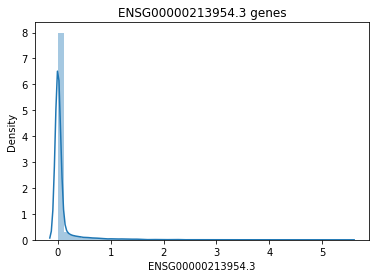

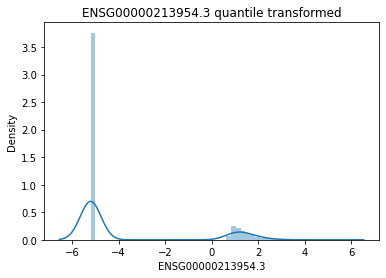

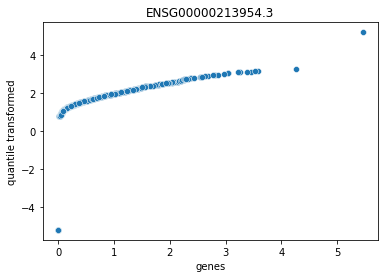

In [28]:
plot_trnsfrm_effect_example(expr_df, traits_qtnorm_df,
                            bf_label=quant_type, 
                            af_label='quantile transformed')

### generate covariates for variance

#### load tissue elevated genes to remove from variance consideration

In [29]:
tissue_genes_df = pd.read_csv(tissue_genes_file)
print(tissue_genes_df.shape)
# display(tissue_genes_df.head())

(610, 1)


In [30]:
tissue_gene_ids = tissue_genes_df['ID'].unique()

# save to feature IDs to exclude from variance detection
pd.DataFrame(tissue_gene_ids, columns=['id']).to_csv(feature_ids_exclude_var_file, 
                                                     index=False)

#### calculate, plot detection rates and subset well detected expression

minimun genes value is 0.95
58294 features with mean missing rate = 0.6793151953888908
8266 samples with mean missing rate = 0.679248729736269


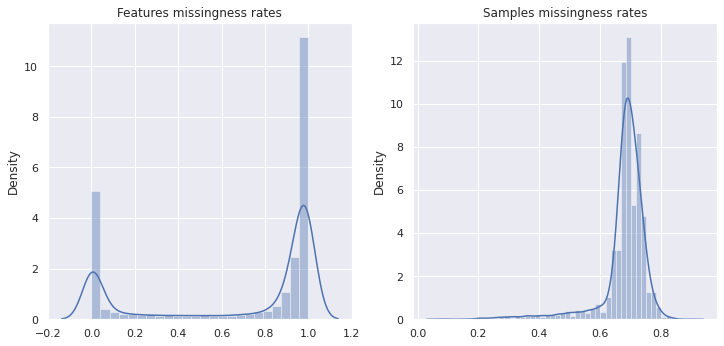

features with bad call rates shape (42812,), fraction of features with bad rates 0.7344152056815453
shape of well detected quants (8266, 15482)
CPU times: user 53.1 s, sys: 3.16 s, total: 56.3 s
Wall time: 49.4 s


In [31]:
%%time
# trait_miss_rates, sample_miss_rates = calculate_detection_rates(expr_df, quant_type)
trait_miss_rates, sample_miss_rates = calculate_detection_rates(expr_df, quant_type, 
                                                                min_expr_value=0.95)
plot_missing_rates(trait_miss_rates, sample_miss_rates)
bad_call_rate_features = bad_callrate_features(trait_miss_rates, max_missing_rate)
traits_qtnorm_df = subset_well_detected_features(traits_qtnorm_df, bad_call_rate_features)

#### save quantile standardized, well detected data for all days

In [32]:
write_df_to_hdf(traits_qtnorm_df, norm_file)

#### exclude low variance genes from covariate generation

In [33]:
quants_var_df = exclude_low_var_features(traits_qtnorm_df)

count    15482.000000
mean         1.071103
std          0.407818
min          1.001518
25%          1.002594
50%          1.003033
75%          1.003669
max          6.138022
dtype: float64
shape of the features to keep (11611,)
shape of input features df (8266, 15482)
shape of variance fatures df (8266, 11611)


### take a look at the data

#### generate unknown covariates and see if know covariates are source of variations

In [34]:
# also exclude sex and tissue elevated genes
variance_features = set(quants_var_df.columns) - set(tissue_gene_ids) - set(sex_chr_gene_ids)
print(len(variance_features))

10805


The dimensions of the umap df and the traits are (8266, 36)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Plate,x_umap,0.290014,regression,True,mean absolute error,2.65851,1.887504,DecisionTreeRegressor()
1,Box,x_umap,0.281522,regression,True,mean absolute error,2.65851,1.910080,DecisionTreeRegressor()
2,visit_month,x_umap,0.163125,regression,True,mean absolute error,2.65851,2.224842,DecisionTreeRegressor()
3,visit_name,x_umap,0.163120,regression,True,mean absolute error,2.65851,2.224854,DecisionTreeRegressor()
4,cohort,x_umap,0.162713,regression,True,mean absolute error,2.65851,2.225935,DecisionTreeRegressor()
5,diagnosis_at_baseline,x_umap,0.102699,regression,True,mean absolute error,2.65851,2.385484,DecisionTreeRegressor()
6,diagnosis_latest,x_umap,0.099585,regression,True,mean absolute error,2.65851,2.393762,DecisionTreeRegressor()
7,study_arm,x_umap,0.066184,regression,True,mean absolute error,2.65851,2.482560,DecisionTreeRegressor()
8,Recruitment,x_umap,0.058007,regression,True,mean absolute error,2.65851,2.504298,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,RIN_Value,y_umap,0.129448,regression,True,mean absolute error,1.304327,1.135484,DecisionTreeRegressor()


found 10 covariates that may preditct target covariates
(84, 9)
(12, 12)


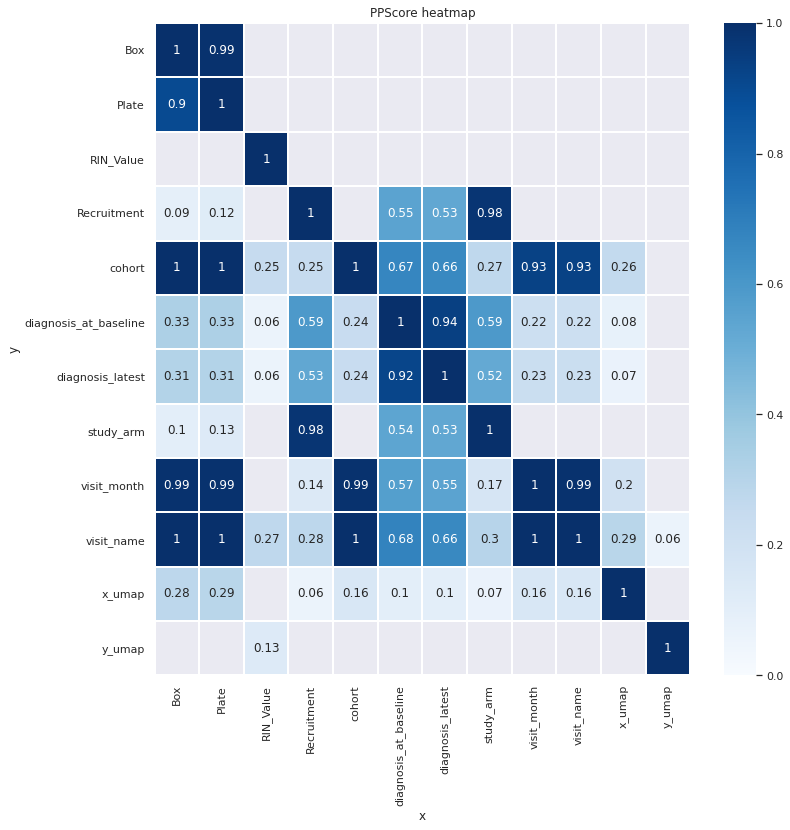

categoricals shape (8266, 8)
one-hot encoded categoricals shape (8266, 240)
new covs df shape (8266, 252)
(12, 2)


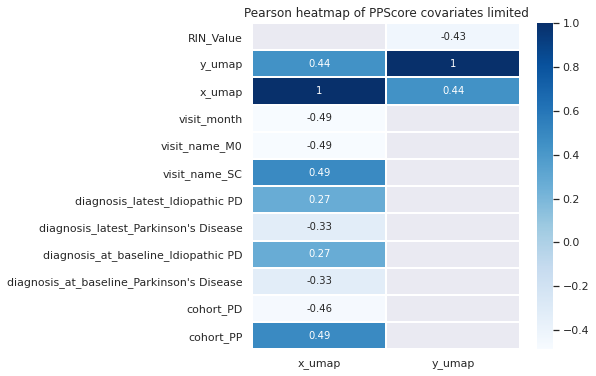

CPU times: user 1min 11s, sys: 1.12 s, total: 1min 12s
Wall time: 45.4 s


In [35]:
%%time
umap_df = generate_umap_covs_df(quants_var_df[variance_features], covs_df)
covs_target_list = ['x_umap', 'y_umap']
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
# plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

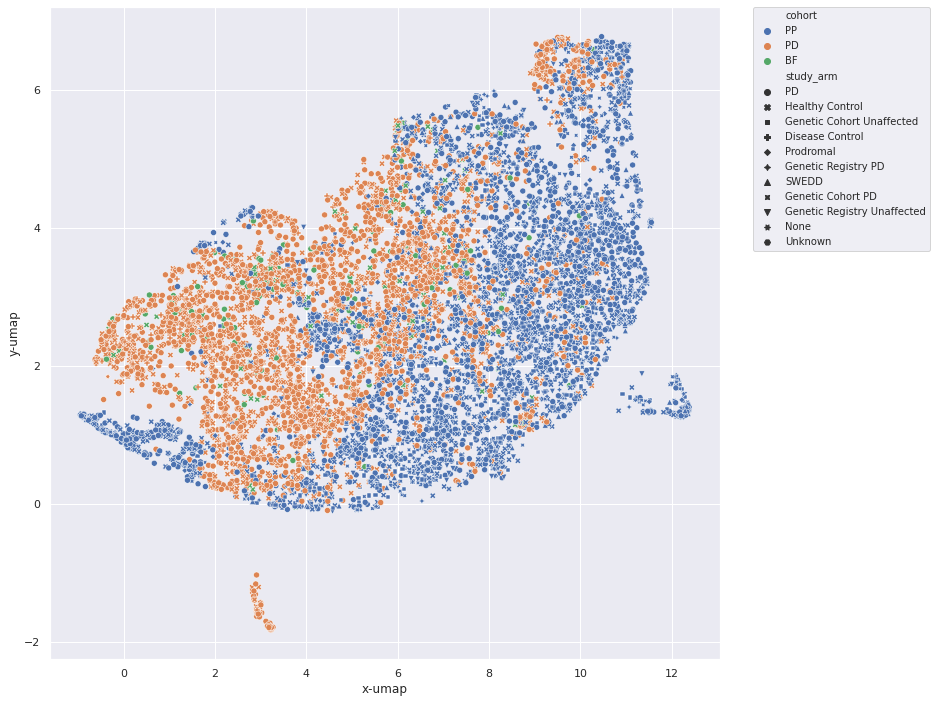

In [36]:
plot_umap_clusters(umap_df, hue_cov='cohort', style_cov='study_arm')

In [37]:
# plot_umap_clusters(umap_df, hue_cov='cohort', style_cov='study_arm')
# keep

In [38]:
# outlier = umap_df.loc[umap_df['x_umap'] > 6]
# print(outlier.shape)
# outlier.to_csv('/home/jupyter/amppd/sample_info/outliers.txt')

#### keep created covars and save them

In [39]:
# standardize the covariates
umap_covs_df = quantile_transform_df(umap_df[covs_target_list])
# now save the covariates
umap_covs_df.to_csv(umap_covs_file)

#### covariate adjust the normalized data by the covariates

In [40]:
# check to see in df's have same indices
if not traits_qtnorm_df.index.equals(umap_covs_df.index):
    print('indices are not equal re-index')
    umap_covs_df.reindex(traits_qtnorm_df.index)
    
traits_qtnorm_df.index.equals(umap_covs_df.index)  

True

In [41]:
%%time

residuals_df, cov_scores_df = covariate_residuals(traits_qtnorm_df, umap_covs_df)

#take a peek at the data
print(residuals_df.shape)
print(cov_scores_df.shape)

# print(cov_scores_df.head())

(8266, 15482)
(15482, 1)
CPU times: user 10min 14s, sys: 12.1 s, total: 10min 26s
Wall time: 1min 19s


              score
count  15482.000000
mean       0.567999
std        0.194313
min        0.000000
25%        0.457000
50%        0.615000
75%        0.719000
max        0.891000


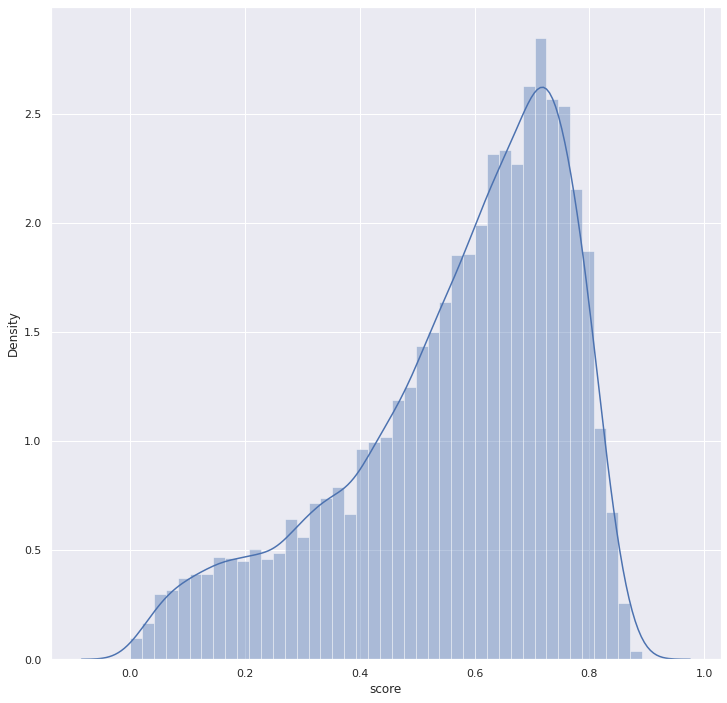

In [42]:
# get a summary of the covariates model scores
print(cov_scores_df.describe())
# look at the distribution of covariate model scores, 
# ie get a sense any gene driven by covariates
sns.set()
plt.figure(figsize=(12,12))
sns.distplot(cov_scores_df['score'])
plt.show()

#### save quantile normalized and covariate adjusted data

In [43]:
%%time 

residuals_df.to_hdf(adj_expr_file, key='expression', mode='w')

CPU times: user 912 ms, sys: 1.27 s, total: 2.18 s
Wall time: 9 s


#### take a look at the normalized and covariate adjusted data

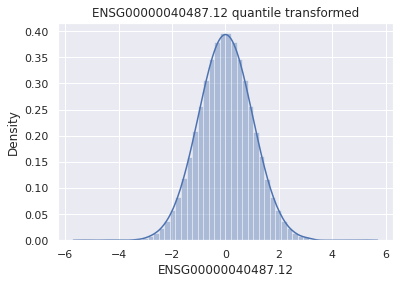

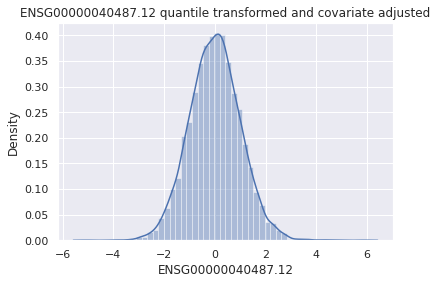

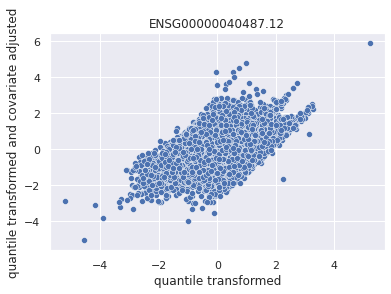

In [44]:
plot_trnsfrm_effect_example(traits_qtnorm_df, residuals_df)

                    score
geneID                   
ENSG00000180398.12  0.891


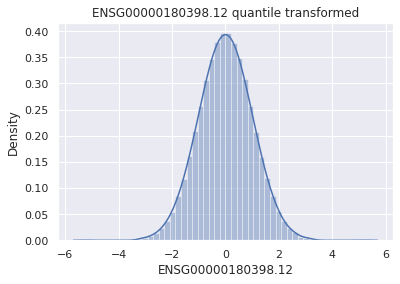

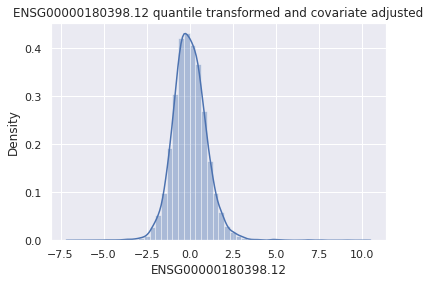

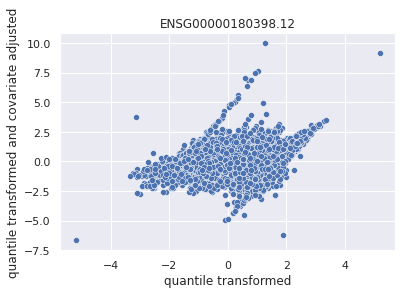

In [45]:
# find gene with largest score
large_adj_trait = cov_scores_df.loc[cov_scores_df['score'] == max(cov_scores_df['score'])]
print(large_adj_trait)
large_adj_traid_id = large_adj_trait.index.values[0]

# spot check same gene with largest adjustment effect
plot_trnsfrm_effect_example(traits_qtnorm_df, residuals_df, large_adj_traid_id)

#### what are the post normalization and covariate adjusted umap variables correlated with

The dimensions of the umap df and the traits are (8266, 36)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Plate,x_umap,0.353522,regression,True,mean absolute error,1.62213,1.048671,DecisionTreeRegressor()
1,Box,x_umap,0.330692,regression,True,mean absolute error,1.62213,1.085705,DecisionTreeRegressor()
2,cohort,x_umap,0.169849,regression,True,mean absolute error,1.62213,1.346612,DecisionTreeRegressor()
3,visit_name,x_umap,0.168855,regression,True,mean absolute error,1.62213,1.348225,DecisionTreeRegressor()
4,visit_month,x_umap,0.168815,regression,True,mean absolute error,1.62213,1.348290,DecisionTreeRegressor()
5,diagnosis_latest,x_umap,0.098484,regression,True,mean absolute error,1.62213,1.462376,DecisionTreeRegressor()
6,diagnosis_at_baseline,x_umap,0.098134,regression,True,mean absolute error,1.62213,1.462944,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Plate,y_umap,0.068258,regression,True,mean absolute error,1.727902,1.609958,DecisionTreeRegressor()
1,Box,y_umap,0.057440,regression,True,mean absolute error,1.727902,1.628652,DecisionTreeRegressor()


found 9 covariates that may preditct target covariates
(57, 9)
(9, 9)


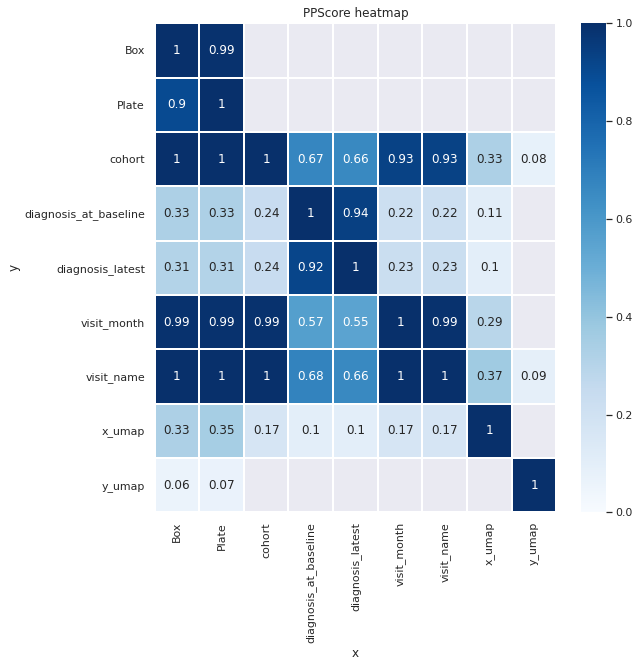

categoricals shape (8266, 6)
one-hot encoded categoricals shape (8266, 220)
new covs df shape (8266, 229)
(13, 2)


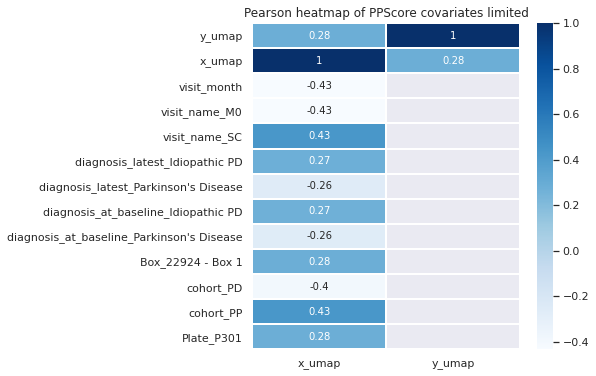

CPU times: user 1min 14s, sys: 1.26 s, total: 1min 16s
Wall time: 32.8 s


In [46]:
%%time
umap_df = generate_umap_covs_df(residuals_df, covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
# plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

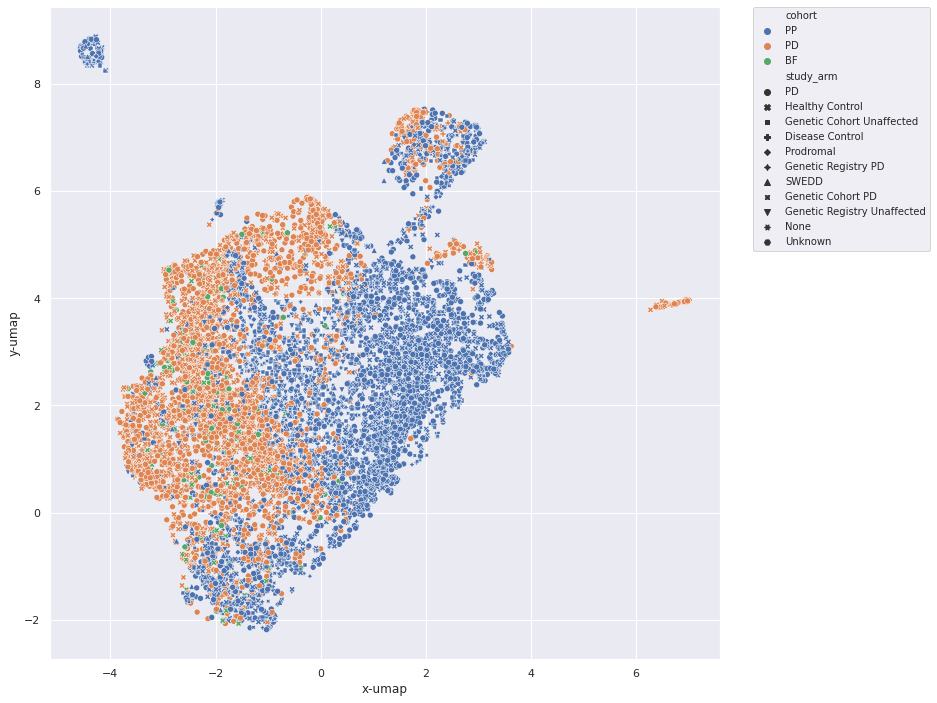

In [47]:
plot_umap_clusters(umap_df, hue_cov='cohort', style_cov='study_arm')

In [48]:
outlier = umap_df.loc[umap_df['x_umap'] > 6]
print(outlier.shape)
print(outlier['Plate'].value_counts())
print(outlier['Box'].value_counts())
print(outlier['cohort'].value_counts())

(67, 36)
P301    66
P340     1
Name: Plate, dtype: int64
22924 - Box 1    66
22928 Box 40      1
Name: Box, dtype: int64
PD    67
Name: cohort, dtype: int64


In [49]:
# outlier = umap_df.loc[(umap_df['x_umap'] > 7) | (umap_df['y_umap'] > 7) ]
# print(outlier.shape)
# outlier.to_csv(outlier_samples_file)

In [53]:
umap_df.columns

Index(['x_umap', 'y_umap', 'predicted_Lymphocytes', 'predicted_Neutrophils',
       'sex', '_260_280_Ratio', 'case_control_other_at_baseline',
       'predicted_Monocytes', 'ethnicity', 'prodromal_category', 'study_arm',
       'visit_month', 'diagnosis_latest', 'diagnosis_at_baseline',
       'Normalization_Volume__30ng_ul_', 'RIN_Value', 'Plate',
       'Input_RNASeq__ng_', 'age_at_baseline', 'Position',
       'predicted_Basophils', 'visit_name', 'case_control_other_latest',
       '_260_230_Ratio', 'Input_miRNA__ng_', 'education_level_years',
       'predicted_Eosinophils', 'Concentration', 'visit',
       'Submitted_Volume__ul_', 'race', 'Box', 'Recruitment', 'cohort',
       'Total_Volume__ul_', 'Specimen_Quantity'],
      dtype='object')

#### since switching to tensorQTL can just use one large transcriptome pheno bed instead of per chrom pheno

In [50]:
# # get gene annots for present features
# gencode_present_df = gencode_df.loc[gencode_df['gene_id'].isin(residuals_df.columns)]
# # tensorQTL pheno bed is rows = features and columns = samples
# # where first four columns are chr, start, end, phenotype_id, then sample1 ... sampleN

# # create dict for renaming columns (samples) from assayid to geno_id
# sample_col_dict = id_map.set_index('assayid').to_dict()['sampleid']

# # transpose the residuals df from sample x feature to feature x sample
# tresiduals_df = residuals_df.transpose()

# # modify annots
# genes_df = gencode_present_df[['seqname', 'start', 'end', 'gene_id', 'strand']].copy()
# genes_df.rename(columns={'seqname': 'chr', 'start': 'fstart', 
#                          'end': 'fend'}, inplace=True)
# # for tensorQTL 'end' column is TSS so set appropriately
# genes_df['end'] = np.where(genes_df['strand'] == '+',  genes_df['fstart'], genes_df['fend'])
# genes_df['start'] = genes_df['end'] - 1
# # there is a feature per transcript, so can be multiple entries per gene, so just keep longest
# genes_df['length'] = genes_df['fend'] - genes_df['fstart']
# genes_df.sort_values(by=['gene_id', 'length'], inplace=True, ascending=False)
# print(genes_df.shape)
# genes_df.drop_duplicates(subset=['gene_id'], keep='first', inplace=True, ignore_index=True)
# genes_df.set_index('gene_id', inplace=True, drop=False)
# genes_df = genes_df.reindex(tresiduals_df.index)

# # insert the feature annots
# tresiduals_df.insert( 0, column='chr', value=genes_df['chr'])
# tresiduals_df.insert( 1, column='start', value=genes_df['start'])
# tresiduals_df.insert( 2, column='end', value=genes_df['end'])
# tresiduals_df.insert( 3, column='phenotype_id', value=genes_df['gene_id'])

# # now rename sample ids in columns
# tresiduals_df.rename(columns=sample_col_dict, inplace=True)

# tresiduals_df.to_csv(tnsrqtl_pheno_file, index=False, sep='\t')